In [3]:
# pyrates imports
from pyrates.frontend import CircuitTemplate
from pyrates.backend import ComputeGraph
from pyrates.utility import plot_timeseries, create_cmap, grid_search

# additional imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# plot settings
plt.style.reload_library()
plt.style.use('ggplot')
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['axes.titlesize'] = 28
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['axes.labelcolor'] = 'black'
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 28
mpl.rcParams['ytick.labelsize'] = 28
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['legend.fontsize'] = 20

%matplotlib inline

PyRates Montbrio Model Simulations
==================================

Below, you will find the code to run the Montbrio model simulations described in detail in "Gast, R. et al. (2018) PyRates - A Python framework for neural modeling and simulations on parallel hardware". These simulations test the correct dynamic behavior of a single Montbrio for a number of different model parametrizations. The Montbrio model is a mean-field model of a globally coupled population of quadratic integrate-and-fire neurons, initially proposed by Montbrio and colleagues in 2015: "Montbrio et al. (2015) ....". The PyRates model implementation can be found under templates/montbrio.

Simulation 1: Monbrio model response to constant forcing
--------------------------------------------------------

In the following cells, we examine the dynamic response of the Montbrio model to a constant external input. The dynamic response of the Montbrio model is defined as its average membrane potential and average firing rate time traces. Model parameters and simulation configuration follow Montbrio et al. (2015). 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [2]:
dt = 1e-4                                      # integration step size in s
dts = 1e-3                                     # variable storage sub-sampling step size in s
sub = int(dts/dt)                              # sub-sampling rate
T = 42.                                        # total simulation time in s
inp = np.zeros((int(T/dt), 1))                 # external input to the population
inp[int(6./dt):int((T-12.)/dt)] = 3.

2) In the cell below, the PyRates model will be initialized and afterwards, a simulation will be run.

In [3]:
circuit = CircuitTemplate.from_yaml("model_templates.montbrio.simple_montbrio.Net1").apply()     # loads the model template
compute_graph = ComputeGraph(circuit, vectorization="none", dt=dt)                          # initializes the model in pyrates

result = compute_graph.run(T,                                                               # runs the simulation
                           inputs={"Pop1.0/Op_e.0/inp": inp},                    
                           outputs={"r": "Pop1.0/Op_e.0/r",
                                    "v": "Pop1.0/Op_e.0/v"},
                           sampling_step_size=dts)

result['input'] = inp[::sub, 0]                                                                 # adds the input to the results
result = result.iloc[result.index >1.0, :]

vectorizing the graph nodes...
building the compute graph...
Preparing the simulation...
Running the simulation...
finished!


3) Results visualization: In the cell below, the resulting timeseries are plotted.

Text(0.5, 1.0, 'Constant input')

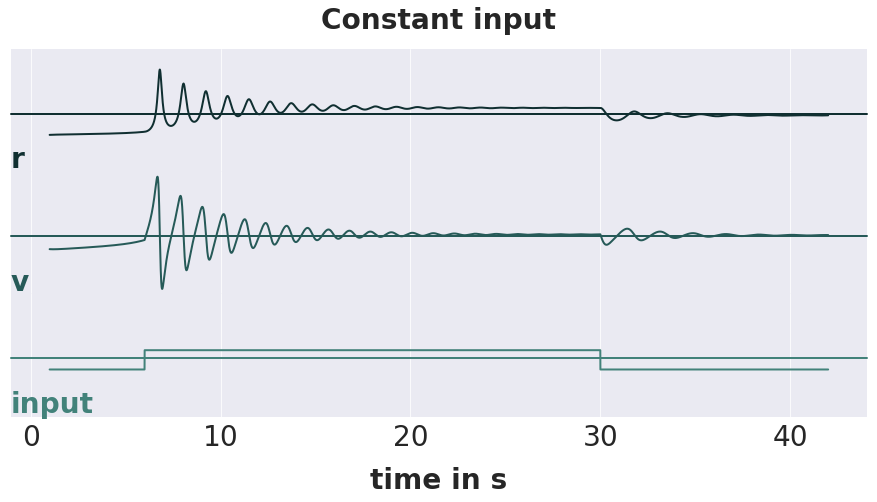

In [4]:
# create colormap
cm = create_cmap('pyrates_green', as_cmap=False, reverse=True)

# plot the results
ax = plot_timeseries(result, plot_style='ridge_plot', demean=True, hspace=-.01, 
                     fontsize=28, aspect=6, height=2.0, cmap=cm)

# adjust the axes
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(13., 7.)
ax.set_xlabel('time in s', labelpad=15.)
fig.axes[0].set_title('Constant input', pad=20.)

#plt.savefig('Gast_2018_PyRates_Montbrio_constant.svg', format='svg')

Simulation 2: Monbrio model response to periodic forcing
--------------------------------------------------------

In the following cells, we examine the dynamic response of the Montbrio model to a periodic external input. The dynamic response of the Montbrio model is defined as its average membrane potential and average firing rate time traces. Model parameters and simulation configuration follow Montbrio et al. (2015). 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [5]:
dt = 1e-4  
dts= 1e-3
sub = int(dts/dt)
T = 82.                                       
inp = np.zeros((int(T/dt), 1))                 
inp[int(4./dt):, 0] = 3. * np.sin(np.pi/20. * np.arange(4., T, dt))      # defines oscillatory input of 0.05 Hz

2) In the cell below, the PyRates model will be initialized and afterwards, a simulation will be run.

In [6]:
circuit = CircuitTemplate.from_yaml("model_templates.montbrio.simple_montbrio.Net1").apply()
compute_graph = ComputeGraph(circuit, vectorization="none", dt=dt)

result = compute_graph.run(T, 
                           inputs={"Pop1.0/Op_e.0/inp": inp},
                           outputs={"r": "Pop1.0/Op_e.0/r",
                                    "v": "Pop1.0/Op_e.0/v"},
                           sampling_step_size=dts)

result['input'] = inp[::sub, 0]
result = result.iloc[result.index >1.0, :]

vectorizing the graph nodes...
building the compute graph...
Preparing the simulation...
Running the simulation...
finished!


3) Results visualization: In the cell below, the resulting timeseries are plotted.

Text(0.5, 1.0, 'Oscillatory input (0.05 Hz.)')

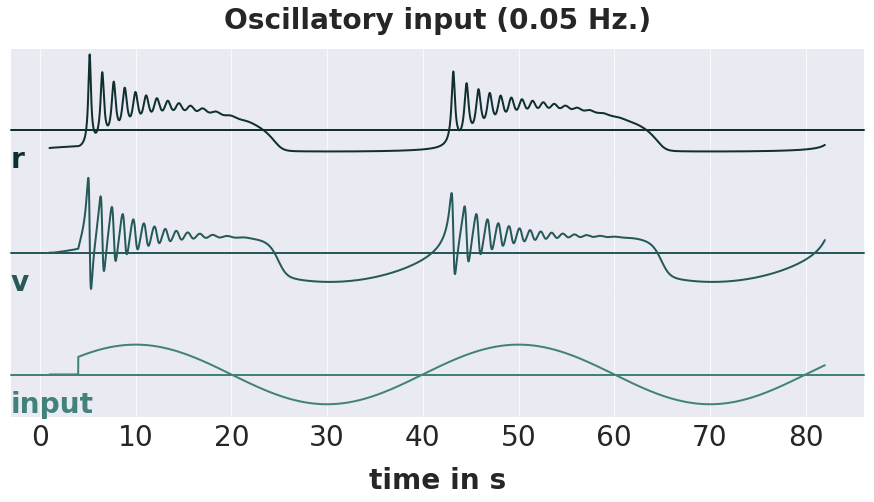

In [7]:
# create colormap
cm = create_cmap('pyrates_green', as_cmap=False, reverse=True)

# plot the results
ax = plot_timeseries(result, plot_style='ridge_plot', demean=True, hspace=-.01, 
                     fontsize=28, aspect=6, height=2.0, cmap=cm)

# adjust the axes
fig, ax = plt.gcf(), plt.gca()
fig.set_size_inches(13., 7.)
ax.set_xlabel('time in s', labelpad=15.)
fig.axes[0].set_title('Oscillatory input (0.05 Hz.)', pad=20.)

#plt.savefig('Gast_2018_PyRates_Montbrio_oscillatory.svg', format='svg')

Simulation 3: Two delay-coupled Monbrio models
--------------------------------------------------------------

In the following cells, we examine the coupling dynamics of two delay-coupled Montbrio models to changes in the delay and strength of the bi-directional coupling. The coupling is quantified by the coherence evaluated at the intrinsic frequencies of the nodes. Model parameters are chosen such that the models express a single focus equilibrium. 

1) Parameter definition:  In the following cell, the different conditions and basic simulation parameters are defined.

In [7]:
dt = 1e-3  
dts= 1e-2
sub = int(dts/dt)
T = 80.0

param_grid = {'c': [0.1, 1.0, 10.0, 100.0], 'd': [0.1, 0.2, 0.4, 0.8, 1.6, 3.2, 6.4, 12.8]}
param_map = {'c': {'vars': ['weight'], 'edges': [('E1.0', 'E2.0'), ('E2.0', 'E1.0')]},
             'd': {'vars': ['delay'], 'edges': [('E1.0', 'E2.0'), ('E2.0', 'E1.0')]}}

In [9]:
results = grid_search(circuit_template="model_templates.montbrio.simple_montbrio.Net4",
                      param_grid=param_grid, param_map=param_map,
                      inputs={}, outputs={"r1": "E1.0/Op_e.0/r"},
                      dt=dt, simulation_time=T, permute_grid=True, sampling_step_size=dts,
                      solver='euler')

vectorizing the graph nodes...
building the compute graph...
Preparing the simulation...
Running the simulation...


/home/rgast/PycharmProjects/PyRates/documentation/pyrates_build/net0/layer_4/op_0.py:4: RuntimeWarning: overflow encountered in multiply
  r_delta_0[:] = np.add(c_23,np.divide(np.multiply(np.multiply(c_15,r_1),v),c_16))
/home/rgast/PycharmProjects/PyRates/documentation/pyrates_build/net0/layer_4/op_1.py:4: RuntimeWarning: overflow encountered in power
  v_delta_0[:] = np.subtract(np.subtract(np.add(np.divide(np.add(np.add(np.power(v_0,c_31),c_32),inp),c_33),np.multiply(c_30,np.add(r_5,np.expand_dims(r_e_2,c_29)))),np.multiply(c_28,r_i)),np.multiply(c_27,np.power(np.multiply(c_25,r_3),c_26)))
/home/rgast/PycharmProjects/PyRates/documentation/pyrates_build/net0/layer_4/op_1.py:4: RuntimeWarning: invalid value encountered in subtract
  v_delta_0[:] = np.subtract(np.subtract(np.add(np.divide(np.add(np.add(np.power(v_0,c_31),c_32),inp),c_33),np.multiply(c_30,np.add(r_5,np.expand_dims(r_e_2,c_29)))),np.multiply(c_28,r_i)),np.multiply(c_27,np.power(np.multiply(c_25,r_3),c_26)))
/home/rgast/Py

finished!


AssertionError: Number of manager items must equal union of block items
# manager items: 32, # tot_items: 0

In [ ]:
results.plot()